## Forcasting Future Stock Prices using Monte Carlo Simulation

###### Author : E. Delali Aggor

###### Introduction
Monte Carlo Simulations are an incredibly powerful technique used to understand the impact of risk and uncertainty when making a decision. It simulates/runs an enourmous amount of trials with different random numbers generated from an underlying distribution for the uncertain variables. With the Monte Carlo simulation, we are interested in observing the different possible outcome of a future event.

Here, we will examine how to forecast stock prices using a Monte Carlo simulation.

To forecast today's stock price, let's look at the following formula:

$$\text{Price Today}\; (S_t) = \text{Price Yesterday}\; (S_0) * e^{r}$$

This means that, the price of a share today is equal to the price of the same share yesterday multiplied by $e$ to the
power of $r$ where $r$ is the log return of the share. It's main added value is it allows us to depict today's stock price as a function of yesterday's stock price and the daily return we'll have. Yesterday's stock price is know but we do not know the daily return i.e "r" as it is a random variable.

Brownian motion is a concept that would allow us to model such randomness.It is a stochastic process used for modeling random behavior over time. The formula we can use is made of two components:

 
- 1) $\textbf{Drift}$ — A drift is the direction i.e the direction that rates of returns have had in the past.It is the best approximation about the future we have. In summary, The drift is the expected daily return of the stock. Here, the variance is multiplied by 0.5 becasue historical values are eroded in the future.

$$
drift = u - \frac{1}{2} \cdot var      
$$

- 2) $\textbf{ Stock's Volatility/Random Value}$ — This is given by a stock's historical volatility multiplied by Z of a random number between zero and one. The random number from 0 to 1 is a percentage. If we assume expected future returns are distributed normally, Z of the percentage between 0 to 1 would give us the number of standard deviations away from the mean.

give us the number of standard deviations away from the mean.

$$
Random\; Variable = \sigma*Z(Rand(0;1))
$$

Therefore, the equation of a stock's price today becomes

$$
S_t = S_0 \mathbin{\cdot} e^{Drift + Random\; Value}
$$
<br />
where,
$
r = {Drift + Random\; Value}
$

If we repeat this calculation 1000 times, we'll be able to simulate the development of tomorrow's stock price and assess the likelihood it will follow a certain pattern.

### Exploratory Data Analysis

We shall download BASF stock closing price and make analysis of the data.

In [1]:
#import required packages

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as wb    
from scipy.stats import norm
import seaborn as sns

# set plotting parameters
%matplotlib inline
sns.set()
plt.rc("figure", figsize=(16, 8))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

### The Data

- The data extrated is a time series data for every trading day. 

-  We download historical market data from yahoo finance for BASF (BAS.DE). The dataset consists of daily market data such as open, high, low and close prices ranging from 2018-01-01 to 2022-09-30.

- The BASF market data obtained from yahoo finance is made up of 1205 rows and 6 columns. All columns have 1206 non-null values (no missing value).

- The adjusted closing price for the first few years is smaller compared to the closing price as in the table above. The difference is due to dividends paid to stock owners as well as other changes in stock price such as stock splits, increase in capital etc. 

- The date column only include trading days. That is to say that, the date column excludes Saturdays, Sundays and National Holidays as stock markets are not opened on such days.  

- It is worth nothing that, the first two rows (Table descriction) are not counted as part of the rows with data. The first row is the row with data with a date of "2018-01-02". Row one is the next row and so on.

In [2]:
BASF_data = wb.DataReader('BAS.DE', data_source = 'yahoo', start = '2018-01-01', end = '2022-09-30')
BASF_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,91.639999,90.570000,91.559998,91.309998,2418347.0,65.294609
2018-01-03,92.230003,91.320000,91.410004,91.580002,2014077.0,65.487679
2018-01-04,93.809998,92.089996,92.220001,93.550003,2424483.0,66.896408
2018-01-05,94.849998,93.370003,93.410004,94.849998,2147921.0,67.826012
2018-01-08,95.180000,94.379997,94.639999,95.010002,1743044.0,67.940437
...,...,...,...,...,...,...
2022-09-26,40.520000,39.500000,39.500000,39.810001,2280095.0,39.810001
2022-09-27,40.480000,39.419998,40.345001,39.494999,3000536.0,39.494999
2022-09-28,39.580002,37.900002,39.000000,39.415001,4627324.0,39.415001


In [3]:
#General inforamtion about the data

BASF_data.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1205 entries, 2018-01-02 to 2022-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1205 non-null   float64
 1   Low        1205 non-null   float64
 2   Open       1205 non-null   float64
 3   Close      1205 non-null   float64
 4   Volume     1205 non-null   float64
 5   Adj Close  1205 non-null   float64
dtypes: float64(6)
memory usage: 65.9 KB


- Now we extract the column needed for estimating the Call and Put option prices. This is the Adjusted Closing Price.


- The stock's closing price is modified by the adjusted closing price to reflect the stock's worth following any corporate actions such as dividends paid to stock owners and other changes such to stock price such as stock splits etc. 


- When analyzing historical returns or performing a thorough analysis of past performance, it is frequently used.

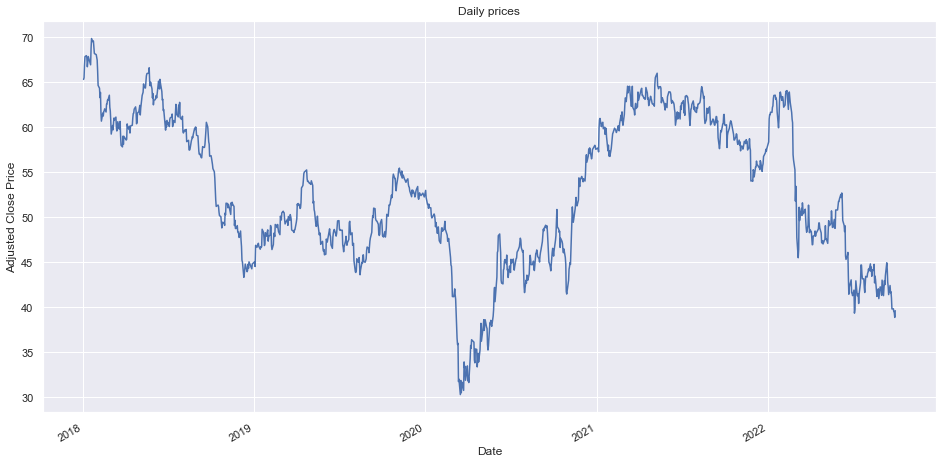

In [4]:
BASF = BASF_data['Adj Close']
BASF.head()

BASF.plot()
plt.title('Daily prices')
plt.ylabel('Adjusted Close Price')
plt.show()

#### Log Returns

We estimate the historical log returns of BASF stock price for the designated period. The method we will apply here is called percent change. We do this with the help of numpy's log function, pct_change() gives the simple returns from the provided data.

The visualization tells us the returns are normally distributed and have a stable mean.

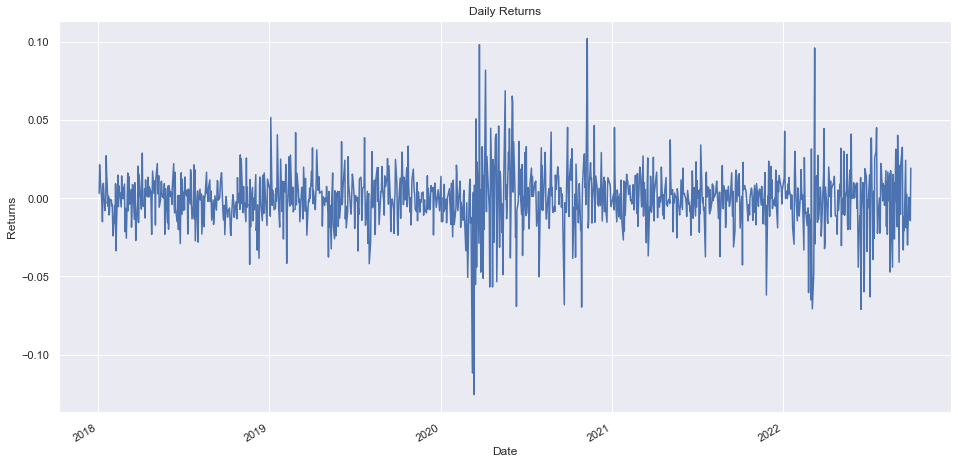

Text(8.120000000000005, 0.5, 'Frequency')

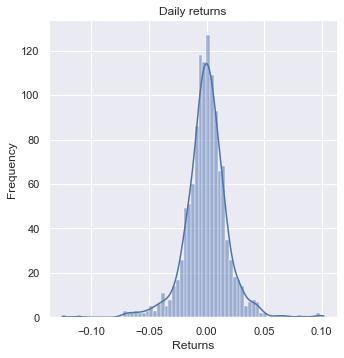

In [5]:
log_returns = np.log(1 + BASF.pct_change())    
log_returns.head(3)

log_returns.plot()
plt.title("Daily Returns")
plt.ylabel("Returns")
plt.show()

sns.displot(log_returns, kde=True)
plt.title("Daily returns")
plt.xlabel("Returns")
plt.ylabel("Frequency")

## Brownian Motion
We said that Brownian motion comprises the sum of the drift and standard deviation, adjusted by e to the power of R. 

#### Drift Component

The mean (u) and variance (var) will be used to compute the drift component. It is the best approximation of future rates of return of the BASF stock. The formular for the drift component is written below:

$$
drift = u - \frac{1}{2} \cdot var      
$$

- Mean and Variance 

Now let's explore the mean and variance of BASF. We shall use the mean and varianace in the calculation of the Brownian motion. Here, we assign the mean value of the log returns to a variable, called "u", and their variance to a variable, called "var". These values will be used to compute the drift component. The drift value is subsequently converted into an array.

In [6]:
u = log_returns.mean()
print(u)

var = log_returns.var()
print(var)

-0.000415349166767697
0.0003499004337600662


In [7]:
#drift

drift = u - (0.5 * var)
print(drift)

-0.0005902993836477301


#### Random Component

So we will use this block for the second part of the expression. We create a variable called stdev and assign to it the standard deviation of log return. The stdev value is later converted into an array with “.values”.

In [8]:
#compute standard deviation

stdev = log_returns.std()    
stdev

0.018705625724900685

### Daily returns

 <br />
Let’s examine 10 possible outcomes. Bind “iterations” to the value of 10.

- time interval
So first I would like to specify the time intervals we will use. we are interested in forecasting the stock price for every trading day a year ahead. So, assign 250 to “t_intervals”. 

- iterations
Then to iterations, I will attribute the value of 10,I'll examine 10 possible outcomes or I am interested in producing 10 series of future stock price predictions. 


Now, for the daily returns, we will have the value of the drift and the product of the standard deviation and the random component created with the help of the norm module. It's percentage value is generated with numpy's rand function using time intervals and iterations specifying the dimensions of the array filled with values from 0 to 1. We use the formula below to calculate daily returns.


$$
daily\_returns = exp({drift} + {stdev} * z), 
$$ 

$$
where,\  z = norm.ppf(np.random.rand(t\_intervals, iterations)
$$

- We shall first convert the drift and random component values into an array.

In [9]:
drift_array = np.array(drift)
print(drift_array)


stdev_array = np.array(stdev)
print(stdev_array)

-0.0005902993836477301
0.018705625724900685


In [10]:
t_intervals = 250
iterations = 10

daily_returns = np.exp(drift_array  + stdev_array * norm.ppf(np.random.rand(t_intervals, iterations)))
daily_returns                 #so we have 250 rows and 10 columns

array([[1.01738729, 1.00982647, 0.99166801, ..., 0.98775374, 0.97604418,
        0.9777833 ],
       [1.01790846, 1.00906485, 0.97935495, ..., 1.0158293 , 0.99332866,
        1.01004161],
       [0.97685757, 0.98418194, 1.0005082 , ..., 0.96678347, 0.988523  ,
        0.98757044],
       ...,
       [1.00864645, 0.98941736, 1.02103202, ..., 0.98784449, 0.97360495,
        1.04157457],
       [0.97032251, 0.98013458, 1.00033284, ..., 1.00886185, 0.98551479,
        1.00114137],
       [1.01614483, 0.9944845 , 0.9898688 , ..., 1.0015136 , 0.98454819,
        0.98233641]])

### Price list

Each price must equal the product of the price observed the previous day and the simulated daily return:
$
S_t = S_0 \mathbin{\cdot} daily\_return_t.
$
Therefore, once we obtain the price in day t, we can estimate the expected stock price we will have in day $t+1$,

$$
S_{t+1} = S_t \mathbin{\cdot} daily\_return_{t+1}
$$ 
$$...$$
  
Then this process will be repeated 250 times and we will obtain a prediction of the company's stock price for 250 days from now

Since, we already created a matrix containing daily returns, we can obtain the price list as shown below. Now, to make credible predictions about the future, the first stock price in our list must be the last one in our data set. It is the current market price.

- We create a variable $S0$ equal to the last adjusted closing price of BASF. Use the “iloc” method.
- then, and Create a variable price_list with the same dimension as the daily_returns matrix. 
- Next, set the values on the first row of the price_list array equal to $S0$.

NumPy has a method that can create an array with the same dimensions as an array that exists and that we have specified. This method is called zeros like. We will obtain an array of 250 by ten elements, just like the dimension of daily returns, and then fill it with zeros.

In [11]:
S0 = BASF.iloc[-1]               #current mrt price S0 as it contains the stock price today at the starting point times zero.
S0

39.599998474121094

In [12]:
price_list = np.zeros_like(daily_returns)
print(price_list)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
price_list[0]      #first row of price_list

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
price_list[0] = S0
price_list

array([[39.59999847, 39.59999847, 39.59999847, ..., 39.59999847,
        39.59999847, 39.59999847],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

- Create a loop in the range (1, t_intervals) that reassigns to the price in time t the product of the price in day (t-1) with the value of the daily returns in t.

- We shall obtain a 250 by 10 array with daily return values,ie 10 sets of 250 random future stock prices.

In [15]:
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]
    
price_list

array([[39.59999847, 39.59999847, 39.59999847, ..., 39.59999847,
        39.59999847, 39.59999847],
       [40.3091736 , 39.95896669, 38.78245438, ..., 40.22683855,
        39.33581327, 39.99764604],
       [39.37632126, 39.32689328, 38.80216366, ..., 38.8906424 ,
        38.88435623, 39.50049276],
       ...,
       [33.31732184, 69.74159275, 53.77871359, ..., 22.98224509,
        44.43371458, 37.47324198],
       [32.32854727, 68.35614705, 53.79661352, ..., 23.18591021,
        43.7900828 , 37.51601299],
       [32.85048608, 67.9791286 , 53.25158949, ..., 23.22100433,
        43.11344696, 36.85334542]])

- Finally, plot the obtained price list data.

Text(0.5, 0, 'Simulated price @ 250 days')

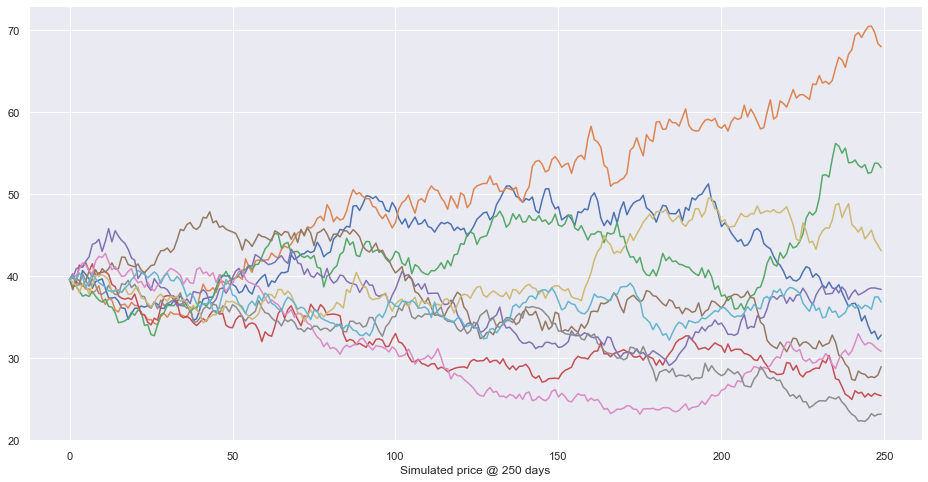

In [17]:
plt.plot(price_list);
plt.xlabel("Simulated price @ 250 days")

In [18]:
#mean of last price list

mean_end_price = round(np.mean(price_list),2)
mean_end_price

38.41

### Conclusion

We obtain 10 possible paths for the expected stock price of BASF, starting from the last day for which we have data from Yahoo. We call these trends iterations and here we have the paths we simulated. We checked the mean of all ending prices
and this allowed us to arrive at the most probable ending point which is the Expected price of 38.41